# Import Libraries


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling

In [ ]:
cd drive/MyDrive/datasets/Cats vs Dogs Classification

/content/drive/MyDrive/datasets/Cats vs Dogs Classification


# Training and validation dataset
Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets.

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_directory = "dataset/training_set"
test_directory = "dataset/test_set"

train_dataset = image_dataset_from_directory(train_directory, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)
validation_dataset = image_dataset_from_directory(test_directory, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# Visualize the images
Now let's take a look at some of the images from the training set: 

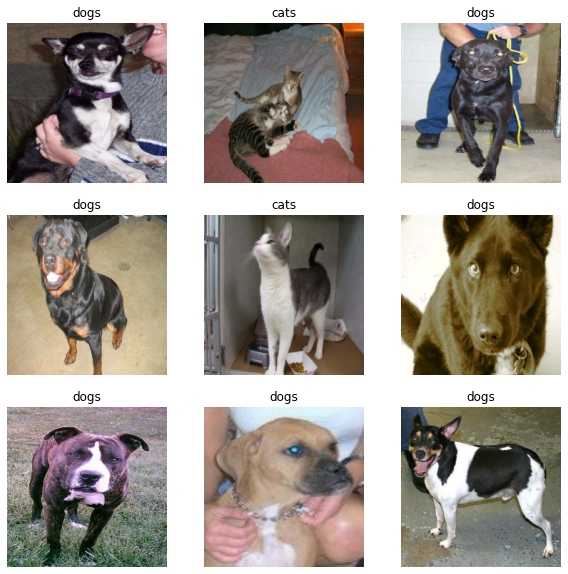

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation
To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them.

In [ ]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

Take a look at how an image from the training set has been augmented with simple transformations

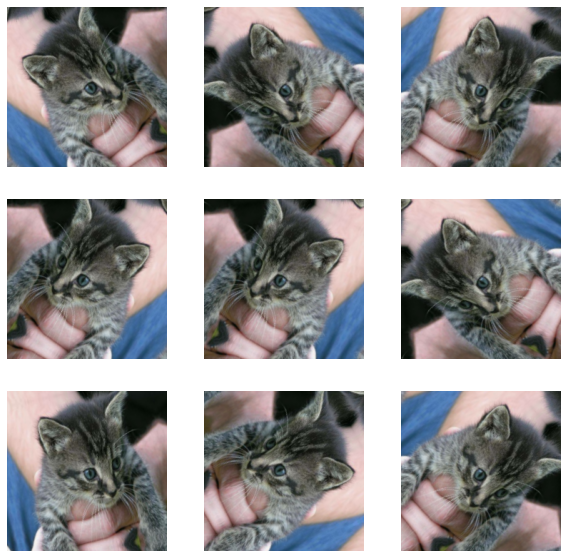

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Define callbacks
Callbacks are the special utilities or functions that are executed during training at given stages of the training procedure.
Callbacks are called when a certain event is triggered

on_epoch_end: this is triggered when an epoch ends.

Here we stop the training as soon as the training accuracy becomes greater than 99%


In [ ]:
class callbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      self.model.stop_training = True
callbacks = callbacks()

# Create the neural net model:

## CNN

In [ ]:
def CNNmodel(input_shape = (224, 224, 3), data_augmentation = data_augmenter(), classes = 1):
  X_input = tfl.Input(input_shape)

  X = data_augmentation(X_input)
  X = tfl.ZeroPadding2D((1, 1))(X)
  X = Rescaling(scale=1./255.)(X)


  X = tfl.Conv2D(32, (3, 3), activation='relu')(X)
  X = tfl.BatchNormalization(axis = -1)(X)
  X = tfl.MaxPooling2D((2, 2))(X)
  X = tfl.Dropout(0.2)(X)

  X = tfl.Conv2D(32, (3, 3), activation='relu')(X)
  X = tfl.BatchNormalization(axis = -1)(X)
  X = tfl.Dropout(0.2)(X)

  X = tfl.Conv2D(64, (3, 3), activation='relu')(X)
  X = tfl.BatchNormalization(axis = -1)(X)
  X = tfl.MaxPooling2D((2, 2))(X)
  X = tfl.Dropout(0.2)(X)

  X = tfl.Conv2D(64, (3, 3), activation='relu')(X)
  X = tfl.BatchNormalization(axis = -1)(X)
  X = tfl.Dropout(0.2)(X)

  X = tfl.Conv2D(128, (3, 3), activation='relu')(X)
  X = tfl.BatchNormalization(axis = -1)(X)
  X = tfl.MaxPooling2D((2, 2))(X)
  X = tfl.Dropout(0.2)(X)

  X = tfl.Conv2D(128, (3, 3), activation='relu')(X)
  X = tfl.BatchNormalization(axis = -1)(X)
  X = tfl.Dropout(0.2)(X)

  X = tfl.Conv2D(256, (3, 3), activation='relu')(X)
  X = tfl.BatchNormalization(axis = -1)(X)
  X = tfl.MaxPooling2D((2, 2))(X)
  X = tfl.Dropout(0.2)(X)

  X = tfl.Conv2D(256, (3, 3), activation='relu')(X)
  X = tfl.BatchNormalization(axis = -1)(X)
  X = tfl.Dropout(0.2)(X)

  X = tfl.AveragePooling2D((2, 2))(X)

  X = tfl.Flatten()(X)
  X = tfl.Dense(128, activation = 'relu')(X)
  X = tfl.Dropout(0.2)(X)
  X = tfl.Dense(128, activation = 'relu')(X)
  X = tfl.Dense(classes, activation = 'sigmoid')(X)

  model = tf.keras.models.Model(inputs = X_input, outputs = X)

  return model

### Analyzing model:

In [ ]:
CNN_model = CNNmodel(input_shape = (224, 224, 3), data_augmentation = data_augmenter(), classes = 1)
print(CNN_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0     

### Model Training

In [ ]:
CNN_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = CNN_model.fit(train_dataset, validation_data=validation_dataset, epochs=64, callbacks = [callbacks])

Epoch 1/64
125/125 [==============================] - 1036s 8s/step - loss: 0.7141 - accuracy: 0.5836 - val_loss: 0.7892 - val_accuracy: 0.4800
Epoch 2/64
125/125 [==============================] - 30s 230ms/step - loss: 0.6990 - accuracy: 0.5955 - val_loss: 0.8530 - val_accuracy: 0.5250
Epoch 3/64
125/125 [==============================] - 30s 230ms/step - loss: 0.6537 - accuracy: 0.6441 - val_loss: 0.9835 - val_accuracy: 0.5335
Epoch 4/64
125/125 [==============================] - 30s 232ms/step - loss: 0.6146 - accuracy: 0.6668 - val_loss: 0.7133 - val_accuracy: 0.5640
Epoch 5/64
125/125 [==============================] - 30s 230ms/step - loss: 0.5907 - accuracy: 0.6949 - val_loss: 0.5788 - val_accuracy: 0.6915
Epoch 6/64
125/125 [==============================] - 30s 232ms/step - loss: 0.5460 - accuracy: 0.7269 - val_loss: 0.6765 - val_accuracy: 0.6725
Epoch 7/64
125/125 [==============================] - 30s 231ms/step - loss: 0.5312 - accuracy: 0.7372 - val_loss: 0.5473 - val_acc

Accuracy:

  Training: 95%
  
  Validation: 93% 

### Visualize the training

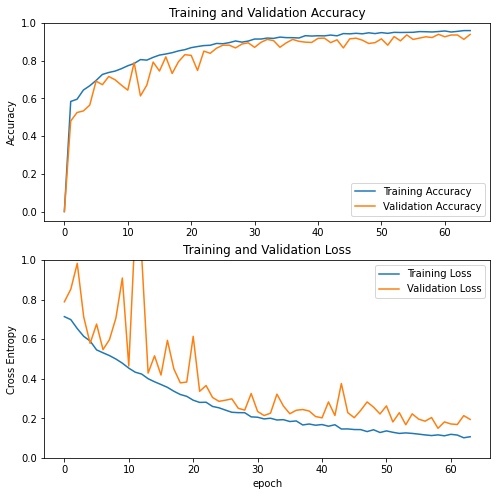

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## VGG 16

In [ ]:
def VGG16model(image_shape = (224, 224), data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)

  base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
  base_model.trainable = True
  fine_tune_at = 14

  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  inputs = tf.keras.Input(shape=input_shape)

  X = data_augmentation(inputs)

  X = tf.keras.applications.vgg16.preprocess_input(X)

  X = base_model(X)

  X = tfl.AveragePooling2D((2, 2))(X)

  X = tfl.Flatten()(X)

  outputs = tfl.Dense(units = 1, activation = 'sigmoid')(X)

  model = tf.keras.Model(inputs, outputs)

  return model

### Analyzing model:

In [ ]:
VGG16_model = VGG16model(image_shape = (224, 224), data_augmentation = data_augmenter())
VGG16_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 512)         0         
____________________________________________________________

### Model Training

In [ ]:
VGG16_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
history = VGG16_model.fit(train_dataset, validation_data = validation_dataset, epochs = 64, callbacks = [callbacks])

Epoch 1/64
125/125 [==============================] - 65s 424ms/step - loss: 0.2490 - accuracy: 0.9220 - val_loss: 0.0968 - val_accuracy: 0.9655
Epoch 2/64
125/125 [==============================] - 51s 398ms/step - loss: 0.0983 - accuracy: 0.9615 - val_loss: 0.0749 - val_accuracy: 0.9790
Epoch 3/64
125/125 [==============================] - 51s 399ms/step - loss: 0.0828 - accuracy: 0.9665 - val_loss: 0.1111 - val_accuracy: 0.9660
Epoch 4/64
125/125 [==============================] - 51s 399ms/step - loss: 0.0629 - accuracy: 0.9754 - val_loss: 0.0611 - val_accuracy: 0.9815
Epoch 5/64
125/125 [==============================] - 50s 391ms/step - loss: 0.0563 - accuracy: 0.9775 - val_loss: 0.0675 - val_accuracy: 0.9820
Epoch 6/64
125/125 [==============================] - 50s 394ms/step - loss: 0.0456 - accuracy: 0.9840 - val_loss: 0.0678 - val_accuracy: 0.9820
Epoch 7/64
125/125 [==============================] - 51s 400ms/step - loss: 0.0515 - accuracy: 0.9800 - val_loss: 0.0731 - val_ac

Accuracy:

  Training: 99%
  
  Validation: 98% 

### Visualize the training

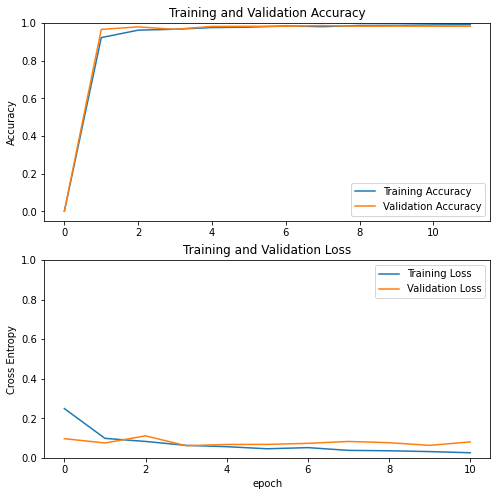

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()